In [1]:
# Load the data and convert it to a GeoDataFrame
from pathlib import Path

import geopandas as gpd
import pandas as pd

example_path = Path("../data/interim/train/95.csv")
example = pd.read_csv(example_path, parse_dates=["date"])

data = example.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(example["longitude"], example["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

print("Data types per column:\n")
print(gdf.dtypes)

Data types per column:

genus               object
date        datetime64[ns]
dbh                float64
geometry          geometry
dtype: object


  0%|          | 0/90 [00:00<?, ?it/s]

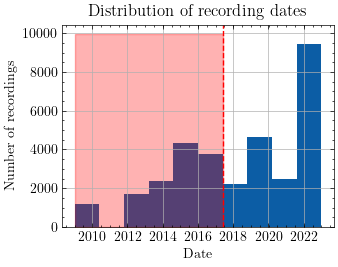

In [2]:
# Plot the distribution of the recording dates
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots  # noqa: F401
from tqdm.notebook import tqdm

plt.style.use("science")

csv_paths = list(Path("../data/interim/train/").glob("*.csv"))
dates = []
for path in tqdm(csv_paths):
    example = pd.read_csv(path, parse_dates=["date"])
    dates.extend(example["date"])

ax = pd.DataFrame(dates).hist()

plt.title("Distribution of recording dates")
plt.xlabel("Date")
plt.ylabel("Number of recordings")

plt.fill_betweenx(
    ax[0, 0].get_ylim(), pd.Timestamp("2017-06-01"), min(dates), color="red", alpha=0.3
)
plt.axvline(pd.Timestamp("2017-06-01"), color="red", linestyle="--")
plt.show()

dates = sum(date < pd.Timestamp("2017-06-01") for date in dates) / len(dates)

In [3]:
# Convert the data to two rasters
from slc.data import compute_target

FIRST_YEAR = 2018

gt_path = Path("../data/processed/")
gt_path.mkdir(parents=True, exist_ok=True)

target_paths = []
for path in tqdm(csv_paths):
    example = pd.read_csv(path, parse_dates=["date"])

    if len(example) == 0:
        print(f"Skipping {path} as it is empty")
        continue

    if example.isna().any(axis=None):
        print(f"Skipping {path} as it contains missing values")
        continue

    dates = example["date"].unique()
    if len(dates) > 1:
        print(f"Skipping {path} as data was collected in multiple years")
        continue

    year = dates[0].year
    if year < FIRST_YEAR:
        print(
            f"Skipping {path} as data was collected before 2018. Level-2A data covers all years fully starting from 2018."
        )
        continue

    area_id = Path(path).stem
    target_path = gt_path / f"target/{area_id}_{year}.tif"
    if not target_path.exists():
        target_path.parent.mkdir(parents=True, exist_ok=True)
        compute_target(target_path=target_path, plot=example)

    target_paths.append(target_path)

  0%|          | 0/90 [00:00<?, ?it/s]

Skipping ../data/interim/train/141.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping ../data/interim/train/97.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping ../data/interim/train/96.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping ../data/interim/train/140.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping ../data/interim/train/80.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping ../data/interim/train/94.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping ../data/interim/train/57.csv as data was collected in multiple years
Skipping ../data/interim/train/143.csv as data was collected before 2018. Level-2A data covers all years fully starting from 2018.
Skipping 

Text(0.7144193946929751, 0, '*in EPSG:32633')

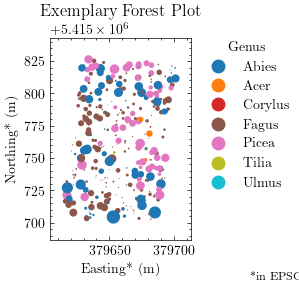

In [4]:
# Plot the data on stem level
from pathlib import Path

import matplotlib.pyplot as plt

gdf_buffer = gdf.copy()
gdf_buffer["geometry"] = gdf_buffer["geometry"].buffer(gdf_buffer["dbh"] * 5)

# Plot
golden_ratio = (1 + 5**0.5) / 2
ax = gdf_buffer.plot(
    column="genus",
    legend=True,
    legend_kwds={
        "title": "Genus",
        "loc": "center left",
        "bbox_to_anchor": (1, 1 / golden_ratio),
    },
)

ax.margins(x=0.1, y=0.1)

# Format
ax.set_title("Exemplary Forest Plot")
ax.set_xlabel("Easting* (m)")
ax.set_ylabel("Northing* (m)")
ax.annotate(
    "*in EPSG:32633",
    (ax.get_position().x1, 0),
    xycoords="figure fraction",
    va="bottom",
    ha="left",
    fontsize="small",
)

# figure_path = f"../reports/figures/ground_truth/{ax.get_title()}.svg"
# Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(figure_path, dpi=300, transparent=True)

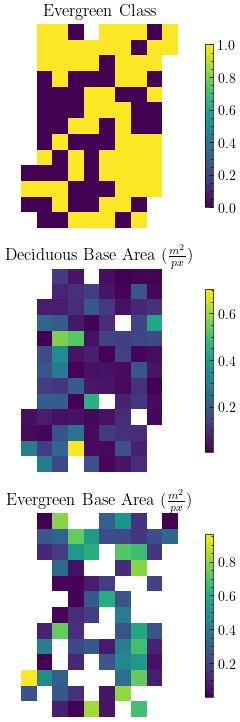

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import numpy as np
import rasterio

from slc.features import genera2target, load_raster

year = example = pd.read_csv(example_path, parse_dates=["date"])[
    "date"
].dt.year.unique()[0]
raster_path = gt_path / "target" / f"{example_path.stem}_{year}.tif"
example_raster = load_raster(raster_path)
example_classification = genera2target(example_raster)
example_regression = genera2target(example_raster, regression=True)

with rasterio.open(raster_path) as src:
    shape = src.shape

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

# Plot the conifer content
target = example_classification.map({"deciduous": 0, "evergreen": 1}).astype(float)
target = target.to_numpy().reshape(shape)
shape = target.shape

norm = plt.Normalize(vmin=0, vmax=1)
img = axes[0].imshow(target, cmap="viridis", norm=norm, interpolation="nearest")
axes[0].set_title("Evergreen Class")
axes[0].axis("off")

fig.colorbar(img, shrink=0.8)

# Plot the broadleaf area
deciduous_area = example_regression["deciduous"].to_numpy().reshape(shape)
deciduous_area[deciduous_area == 0] = np.nan

img = axes[1].imshow(deciduous_area, cmap="viridis", interpolation="nearest")
axes[1].set_title(r"Deciduous Base Area ($\frac{m^2}{px}$)")
axes[1].axis("off")

fig.colorbar(img, shrink=0.8)

# Plot the evergreen area
evergreen_area = example_regression["evergreen"].to_numpy().reshape(shape)
evergreen_area[evergreen_area == 0] = np.nan

img = axes[2].imshow(evergreen_area, cmap="viridis", interpolation="nearest")
axes[2].set_title(r"Evergreen Base Area ($\frac{m^2}{px}$)")
axes[2].axis("off")

fig.colorbar(img, shrink=0.8)

# figure_path = "../reports/figures/ground_truth/Conifer Proportion and Base Areas.svg"
# plt.savefig(figure_path, dpi=300, transparent=True)

  0%|          | 0/51 [00:00<?, ?it/s]

Text(0, 0.5, 'Number of Rasters')

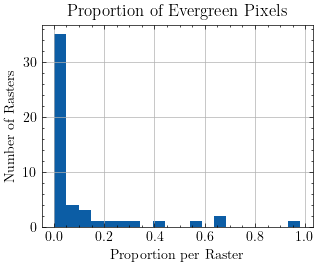

In [6]:
# Compute the proportion of evergreen pixels for every raster and plot it in a kde plot
from slc.features import genera2target, load_raster

proportions = []
for path in tqdm(target_paths):
    raster = load_raster(path, monochrome_as_dataframe=True)
    classification = genera2target(raster)
    proportions.append(classification.map({"deciduous": 0, "evergreen": 1}).mean())

prop = pd.Series(proportions)
ax = prop.hist(bins=20)
ax.set_title("Proportion of Evergreen Pixels")
ax.set_xlabel("Proportion per Raster")
ax.set_ylabel("Number of Rasters")

  0%|          | 0/51 [00:00<?, ?it/s]

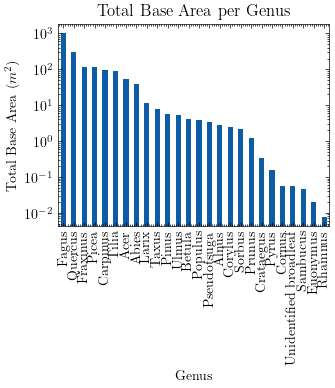

In [7]:
proportions = []
for path in tqdm(target_paths):
    raster = load_raster(path, monochrome_as_dataframe=True)
    proportions.append(raster)

proportions = pd.concat(proportions)
proportions = proportions.fillna(0)

ax = proportions.sum(axis=0).sort_values(ascending=False).plot(kind="bar", logy=True)
ax.set_title("Total Base Area per Genus")
ax.set_xlabel("Genus")
ax.set_ylabel("Total Base Area ($m^2$)")

plt.show()

In [8]:
# Create Level-1C and 2A imagery
from datetime import datetime
from pathlib import Path
from zoneinfo import ZoneInfo

from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from slc.data import sentinel_composite

tz = ZoneInfo("CET")

rmse_scorer = make_scorer(root_mean_squared_error)
level_1c_folder = Path("../data/processed/ground_truth/data_1C/")
level_2a_folder = Path("../data/processed/ground_truth/data_2A/")

# Create the 1C composite if it does not exist
level_1c_folder.mkdir(parents=True, exist_ok=True)
for target_path in tqdm(target_paths):
    data_path = level_1c_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    if not data_path.exists():
        sentinel_composite(
            target_path_from=target_path,
            data_path_to=data_path,
            time_window=(
                datetime(year, 1, 1, tzinfo=tz),
                datetime(year + 1, 1, 1, tzinfo=tz),
            ),
            level_2a=False,
        )

# Create the 2A composite if it does not exist
level_2a_folder.mkdir(parents=True, exist_ok=True)
for target_path in tqdm(target_paths):
    data_path = level_2a_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    if not data_path.exists():
        sentinel_composite(
            target_path_from=target_path,
            data_path_to=data_path,
            time_window=(
                datetime(year, 1, 1, tzinfo=tz),
                datetime(year + 1, 1, 1, tzinfo=tz),
            ),
        )

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [9]:
# Compare it to the baseline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

from slc.features import load_dataset

f1_scorer = make_scorer(f1_score)

# Load data
target_folder = Path("../data/processed/target/")
data_1c, target = load_dataset(data_path=level_1c_folder, target_path=target_folder)
data_2a, _ = load_dataset(data_path=level_2a_folder, target_path=target_folder)

# Cross validate Random Forest on Level-1C data
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=42)
level_1c_result = cross_validate(
    rf_classifier, data_1c, target, cv=5, scoring=f1_scorer, n_jobs=-1
)
level_1c_score = level_1c_result["test_score"].mean()

# Cross validate Random Forest on Level-2A data
level_2a_result = cross_validate(
    rf_classifier, data_2a, target, cv=5, scoring=f1_scorer, n_jobs=-1
)
level_2a_score = level_2a_result["test_score"].mean()

# Print scores
print(f"Level-1C F1 Score: {level_1c_score}")
print(f"Level-2A F1 Score: {level_2a_score}")

Level-1C F1 Score: 0.02066596120971152
Level-2A F1 Score: 0.12440302369098366
